Pattern Recognition 2019 - 2020: Lab 1
==========================
### Christos Lamprakos, 03002910

This document serves as a report for the first lab exercise of the course.
> ***ATTENTION:*** Due to an extremely hasty submission of the pre-lab work and ~~probably OCD-related~~ personal high-quality standards, all questions will be answered again here.

All code produced, along with the report itself, have been uploaded in a relevant GitHub [repo][0]. Environment used for development was Anaconda.

## Initializations
The code below performs all necessary imports for the rest of the project:

[0]: <https://github.com/cappadokes/patrec19/tree/master/labOne>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
import config
from src import datautilus
from src.sklearn_classifiers import EuclideanClassifier
from src.sklearn_classifiers import NaiveBayesClassifier
from src.sklearn_classifiers import NaiveBayesClassifierSmooth
from src.sklearn_classifiers import NaiveBayesClassifierOnes
from src.sklearn_classifiers import NeuralNet0Hidden, NeuralNet1Hidden
from mlxtend.plotting import plot_decision_regions

- ```plt```: for plots.
- ```numpy```: for data representation.
- ```seaborn```: for ~~supposedly by default~~ more elegant plots
- ```sklearn```: for a variety of reasons. Most of the classes' names are self-descriptive.
- ```config```: initializes a very simplistic class which contains information for where the data is stored.
- ```src```: encloses all written code.
- ```datautilus```: contains all data manipulation-related methods. More info upon each method will be given once it's called for the first time.
- ```sklearn_classifiers```: module containing (among others) a fleshed-out version of the code outlined [here][1].
- ```plot_decision_regions```: for Step 13c

> ***CAUTION:*** Assuming an Anaconda dev environment, ```mlxtend``` is the sole external dependency. 

[1]: <https://gist.github.com/georgepar/b53c01466d6649c8583497d120b9b479>

In [2]:
dataHouse = config.ToolConfig ()

The above variable just invokes the constructor for the simplistic ```ToolConfig``` class, which has the following definition:

```python
class ToolConfig ():
    def __init__ (self):
        self.train = './data/train.txt'
        self.test = './data/test.txt'
```

## Step 1
The format of choice for representing our data is ```numpy``` arrays. Thus a convenient way to read the files is via ```loadtxt```. Since both the samples and their labels co-exist in the .txt's, array slicing is used for differentiating.:

```python
def dataReader (train_path, test_path):
    """
    Reads data.
    """
    train_concat = np.loadtxt (train_path)
    test_concat = np.loadtxt (test_path)
    """
    For convenience, the labels are turned 
    from floats to int.
    """
    y_train = train_concat[:, 0].astype (int)
    X_train = train_concat[:, 1:]
    y_test = test_concat[:, 0].astype (int)
    X_test = test_concat[:, 1:]
    return X_train, X_test, y_train, y_test
```

In [3]:
X_train, X_test, y_train, y_test = datautilus.dataReader (dataHouse.train,
                                                          dataHouse.test)

As may be observed, the notebook provides the ```dataReader``` method with the attributes of ```dataHouse```, which are then used for locating the files.

## Step 2
For picking individual samples and their corresponding labels through a given index, the following method was implemented:

```python
def pickDigit (features, patterns, index):
    """
    Returns sample correspoinding to given index.
    """
    true_idx = index-1
    ind_feats = features[true_idx, :]
    ind_id = patterns[true_idx]
    return ind_feats, ind_id
```
> ***ASSUMPTION***: Indexes in the exercise description are **NOT** 0-based. Thus the samples' actual location in the arrays will always be assumed to be the given index minus 1.

To illustrate the picked digit as an image, the following methods were implemented:

```python
def printSingleDigit (feature):
    """
    Plots a single sample.
    """
    fig, axs = plt.subplots ()
    axs, im = digit2Fig (feature, axs)
    fig.colorbar (im)
    axs.set_ylabel ('pixel no.')
    axs.set_xlabel ('pixel no.')
    plt.show ()

def digit2Fig(feature, ax):
    """
    Returns an axes object (for sub-plotting).
    """
    transformed = np.reshape (feature, (16, 16))
    im = ax.imshow (transformed, cmap = 'gist_yarg')
    return ax, im
```
Admittedly, a simpler implementation could have been followed.

As advised in the exercise description, NumPy's ```reshape``` method was used to pixelize the flat-indexed sample features. A colormap reminiscing of black ink on white paper was chosen for naturalness.

Thus it's time to isolate digit #131:

Picking pattern #131...
Done! Number is  0 
Printing...


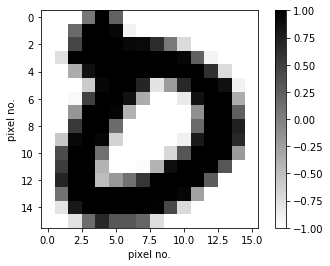

In [4]:
print ('Picking pattern #131...')
feat_131, id_131 = datautilus.pickDigit (X_train, y_train, 131)
print ('Done! Number is ', id_131, '\nPrinting...')

datautilus.printSingleDigit (feat_131)

...well, this doesn't look like a 0. But utter trust is put upon the label-producing procedure.

## Step 3
```subplot``` and the previously-introduced ```digit2Fig``` methods were combined to produce the 10 figures requested.

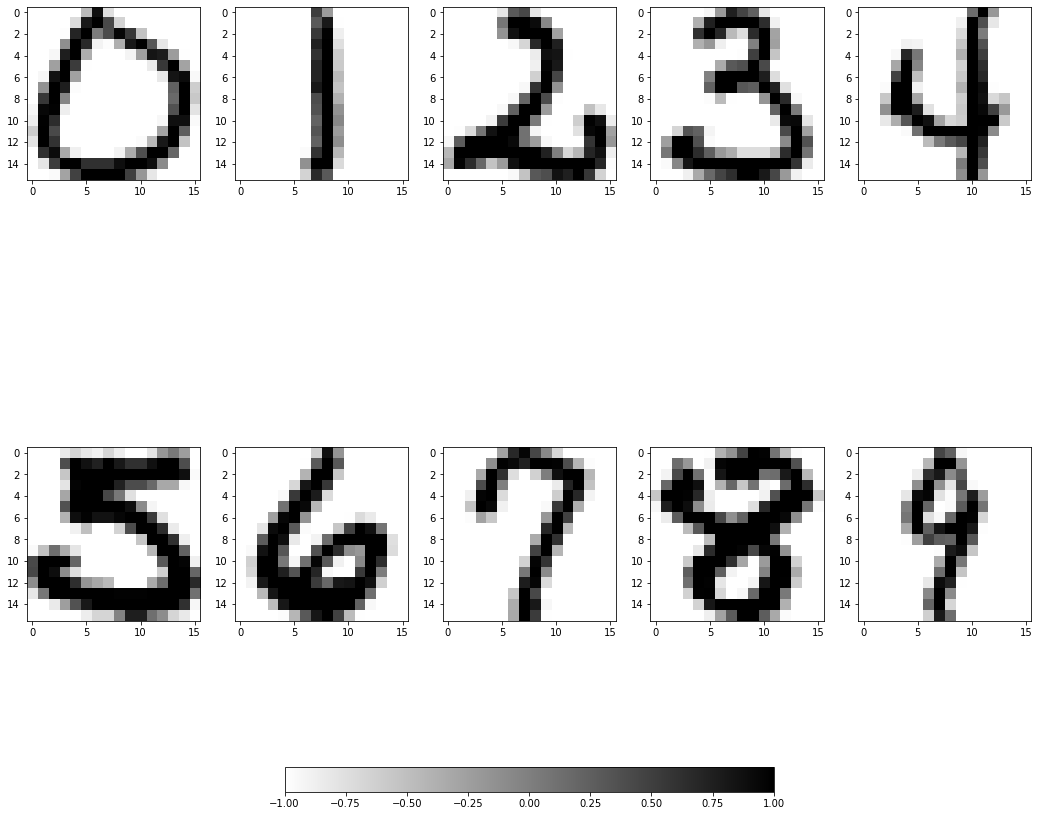

In [5]:
step3_fig, axs3 = plt.subplots (2, 5, figsize = (18, 18))
#This is a very bad scheme to keep track of the subplots.
posx, posy = 0, 0
for num in range(10):
        step3_num = X_train[y_train == num][0, :]
        axs3[posx, posy], im3 = datautilus.digit2Fig (step3_num,
                                                      axs3[posx, posy])
        #posx, posy only serve the subplots' indexing, and could
        #undoubtedly be generated more efficiently...
        posy += 1
        if posy % 5 == 0:
            posy = 0
            posx += 1
step3_fig.colorbar (im3, ax = axs3, orientation = 'horizontal',
                    fraction = .025)
plt.show()

## Steps 4-8
The following method was written to accomodate mean and variance calculations (which were performed through NumPy's ready-to-use array attributes ```mean``` and ```var```):

```python
def analyzeDigits (features, patterns):
    """
    Computes mean and variance values for all pixels (features)
    of all digits.
    """
    for i in range (10):
        feats_val = features[patterns == i]
        mean_val = feats_val.mean (axis = 0)
        var_val = feats_val.var (axis = 0)
        if i == 0:
            mean_all = mean_val
            var_all = var_val
        else:
            mean_all = np.vstack((mean_all, mean_val))
            var_all = np.vstack((var_all, var_val))
    return mean_all, var_all
```
So when invoked, mean and variance is calculated for **all** pixels of **all** digits. To specifically refer to pixel (10, 10), the following formula was employed:

```python
flat_idx = (posx - 1) * 16 + (posy - 1)
```
To print the means and the variances, the already-described ```printSingleDigit``` method was used. 

The code producing the desired output is thus:

For digit 0, mean value of pixel (10, 10) is  -0.927264656616415
For digit 0, variance of pixel (10, 10) is  0.08392455977261963


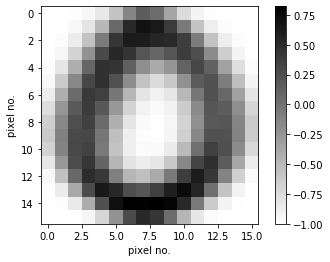

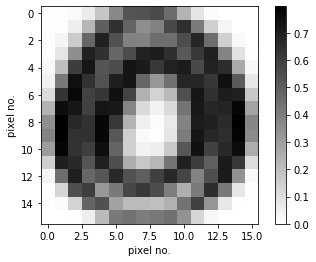

In [6]:
mean_0, var_0 = datautilus.analyzeDigits (X_train, y_train)
flat_idx = 9 * 16 + 9
print ('For digit 0, mean value of pixel (10, 10) is ',
       mean_0[0, flat_idx])
print ('For digit 0, variance of pixel (10, 10) is ',
       var_0[0, flat_idx])
datautilus.printSingleDigit (mean_0[0, :])
datautilus.printSingleDigit (var_0[0, :])

The following points can be made for the above results:
* the shape of the digit has indeed been preserved in both figures. This shows that people actually abide to universal rules in their handwriting, and these rules can in turn be encoded (with some loss) in the features' mean values.
* pixels with high mean value demonstrate low variance, while pixels with low mean value demonstrate high variance.
    - high mean value denotes universally common parts of the digit.
    - high variance denotes 'creative freedom'. Many paths on the grid could have been chosen. The mean is spread, less concentrated.
    - **maybe** high mean/low variance pixels could represent the dominant features of each digit, thus providing a first hint to dimensionality reduction...
* the pixels with the highest mean (and lowest variance) are located at the top point and bottom curve of the digit. This can be explained in the following way:
    - most people start plotting a '0' from the top (universality, high mean). 
    - then, depending on a variety of factors, they continue either clock- or counterclockwise, and they also give the circle a variety of widths (creativity, high variance both in the inner and the outer rings)
    - finally, all circles eventually close. The bottom curve seems even more universal than the top point.

## Step 9
Means and variances over all pixels of all patterns were calculated by using the methods demonstrated above. A ```for``` loop repeatedly invoked ```analyzeDigit``` each time stacking the resulting arrays over the ones already calculated.

> By opting for this 'stacked' representation of means in a (10, 256) ndarray, the potential for vectorized implementation is preserved.

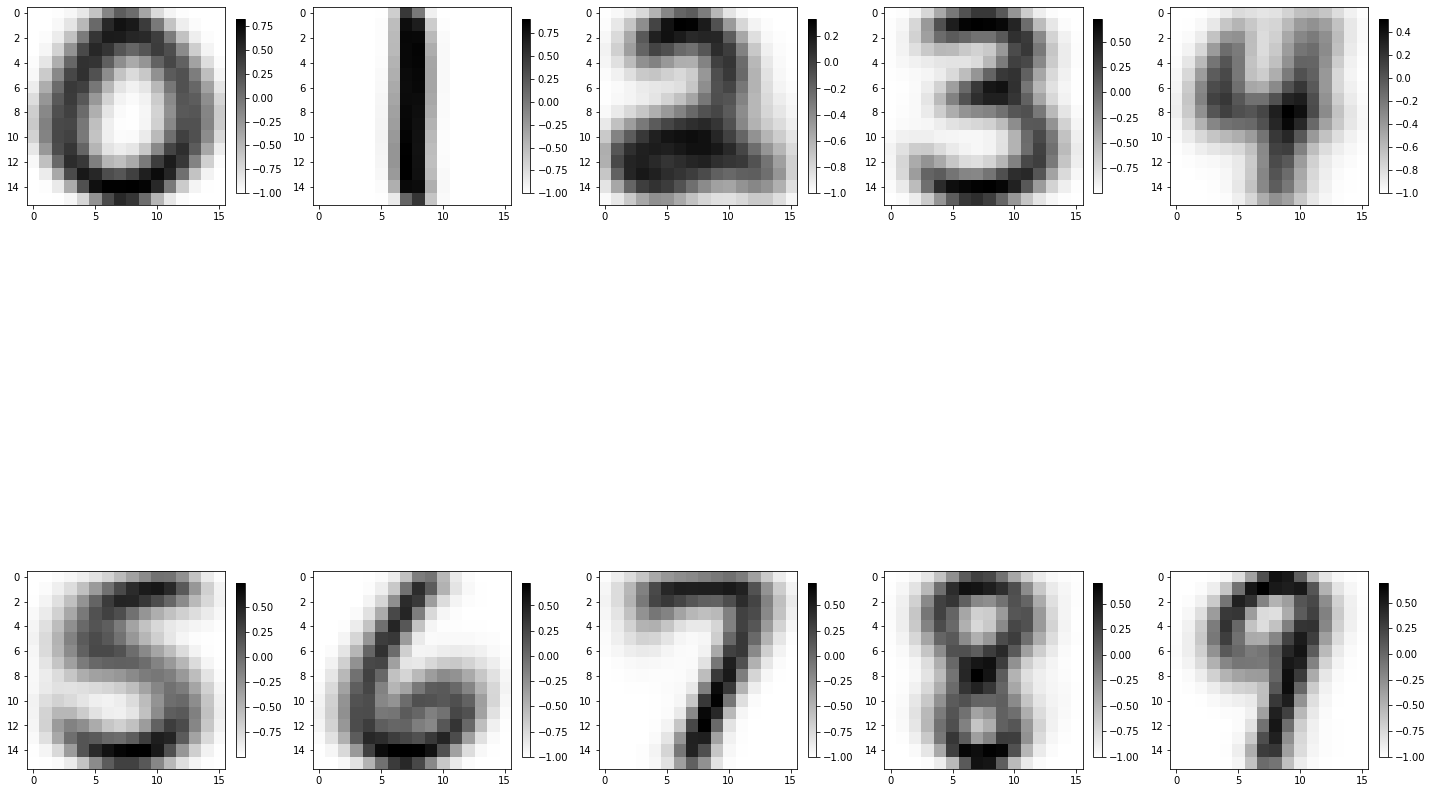

In [7]:
step9_fig, axs9 = plt.subplots (2, 5, figsize = (20, 20))
posx, posy = 0, 0
means_overall, vars_overall = datautilus.analyzeDigits (X_train, y_train)
for num in range(10):
        axs9[posx, posy], im9 = datautilus.digit2Fig (means_overall[num, :],
                                                      axs9[posx, posy])
        step9_fig.colorbar (im9, ax = axs9[posx, posy], fraction = .04)
        posy += 1
        if posy % 5 == 0:
            posy = 0
            posx += 1
step9_fig.tight_layout ()
plt.show ()

What was observed in Step 8 is now found to hold for all 10 digits. Universality of digit parts is translated to high mean values (the straight line of '1', the crossing middle point of '4', the top and bottom of a '3' or an '8'). Shapes have, in general, been preserved.

> ***HYPOTHESIS***: A classifier which uses these mean values as knowledge can **not** perform that bad...

## Step 10
The 101th sample was picked from the train dataset using ```pickDigit``` The following method (more of a simple wrapper for a scikit-learn module) was implemented:

```python
def askEuclid (knowledge, feature):
    """
    Classifies a single sample based on euclidean distance.
    """
    dists = euclidean_distances (knowledge, [feature])
    return np.array (dists).argmin ()
```

By using the ```argmin``` attribute of NumPy arrays, the label corresponding to the minimum euclidean distance is retrieved.

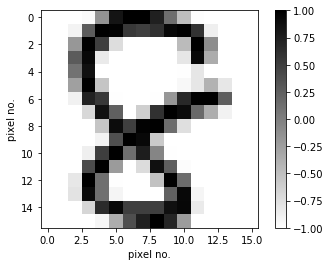

prediction:  8
actual:  8


In [8]:
feat_101, id_101 = datautilus.pickDigit (X_train, y_train, 101)
pred_101 = datautilus.askEuclid (means_overall, feat_101)
datautilus.printSingleDigit (feat_101)
print ('prediction: ', pred_101)
print ('actual: ', int (id_101))

Prediction was correct! This is in accordance to the hypothesis stated in the previous step.

## Step 11
With a vectorized implementation in mind, it is time to utilize the ```means_overall``` array which was calculated during Step 9:

```python
def batchEuclid (features, patterns, knowledge):
    """
    Classifies whole dataset via euclidean distance. Returns score.
    """
    dists = euclidean_distances (knowledge, features)
    preds = np.array (dists).argmin (axis = 0)
    truthVector = (preds.T.astype (float) == patterns)
    pos = truthVector.sum ()
    score = pos / features.shape[0] * 100
    return score
```

In [9]:
score = datautilus.batchEuclid (X_test, y_test, means_overall)
print ('The trained Euclidean classifier performed ', score,
       'successfully on the test dataset.')

The trained Euclidean classifier performed  0.8141504733432985 successfully on the test dataset.


Thus, the hypothesis regarding more-than-mediocre performance of the classifier is backed from the test data. **However**, this could be a case of bias due to uneven split between training and test data, and we cannot be sure until cross-validation is applied.

> Still, 81% is impressive, considering the simplicity of the decision process.

## Step 12
As per the exercise description, [this][1] code was used as an outline. The fleshed-out version used in this notebook can be found [here][2]. The ```predict``` and ```score``` methods are merely a segmentation of ```batchEuclid``` described above. Due to its importance, the ```fit``` method is transcribed below:

```python
    def fit(self, X, y):
        """
        Calculates self.X_mean based on the mean
        feature values in X for each class.
        """
        self.X_mean, useless = datautilus.analyzeDigits (X, y)
        return self
```

To ensure that no bugs exist up until this point, some of the previous questions were repeated, this time employing the scikit-learn estimator:

[2]: <https://github.com/cappadokes/patrec19/blob/master/labOne/src/sklearn_classifiers.py>
[1]: <https://gist.github.com/georgepar/b53c01466d6649c8583497d120b9b479>

In [10]:
lilEuclid = EuclideanClassifier ()
print ('Euclidean classifier initialized. Now fitting on test data...')
lilEuclid.fit (X_train, y_train)
pred_101_sk = lilEuclid.predict ([feat_101])
print ('The scikit-learn EC classifies sample #101 as: ', pred_101_sk)
score_sk = lilEuclid.score (X_test, y_test)
print ('Also, its score on test data is: ', score_sk)

Euclidean classifier initialized. Now fitting on test data...
The scikit-learn EC classifies sample #101 as:  [8]
Also, its score on test data is:  0.8141504733432985


## Step 13
For the cross validation, the existing ```sklearn``` ```cross_validate``` method was utilized. For this to happen, the following steps were taken:
- the train and test datasets and labels were merged.
- a new ```EuclideanClassifier``` object was initialized.

In [11]:
X_total = np.vstack((X_train, X_test))
y_total = np.concatenate((y_train, y_test))
print ('Datasets joined!')
euclidClf = EuclideanClassifier ()
print ('Ready to cross_validate!')
cv_results = cross_validate (euclidClf, X_total, y_total, cv = 5)
print ('CV-complete: ', cv_results)

Datasets joined!
Ready to cross_validate!
CV-complete:  {'fit_time': array([0.0639236 , 0.05412507, 0.02538323, 0.03193021, 0.02162027]), 'score_time': array([0.0055263 , 0.00259566, 0.00120497, 0.00191402, 0.00371623]), 'test_score': array([0.85354077, 0.84425349, 0.84946237, 0.84284177, 0.81877023])}


The cross validation output implies the following:
- the methods of the classifier demonstrated acceptable fit and training times (which are however platform-dependent and thus not entirely indicative of computational complexity).
- performance remained steadily over **80%** in all 5 folds. Thus it is indeed a decent baseline classifier, against which more complex approaches could be compared.

As regards the decision boundary, it could not be plotted with the data in its current multidimensional state. Principal component analysis (```PCA```) was used for dimensionality reduction to 2 dimensions. Also the external library [```mlxtend```][3] was used for plotting the decision region.

> ***ASSUMPTION***: The decision boundary is requested for the test data, on the case of a euclidean classifier trained on the train data.

[3]: <https://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/>

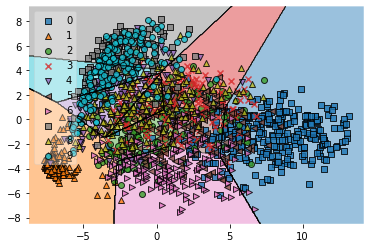

In [12]:
PCA_obj = PCA (n_components = 2)
X_train_reduced = PCA_obj.fit_transform (X_train)
X_test_reduced = PCA_obj.fit_transform (X_test)
pcaEuclid = EuclideanClassifier ()
pcaEuclid.fit (X_train_reduced, y_train)
plot_decision_regions (X_test_reduced, y_test, clf = pcaEuclid, legend = 2)
plt.show ()

The above result has mostly intuitive value, since it does not accurately resemble the classifier built up to this point. Huge overlap can be noted between samples from almost all classes (with the exception of '0', '1' and maybe '6'). The decision regions do not seem to capture the essence of the classes. All this is expected, since an immense dimensionality reduction has taken place.

What could maybe be derived from this figure is a sense of inadequacy of the euclidean classifier to achieve respectable performance in the particular problem. However, the decent baseline stats that the cross validation gave were **not** visible here.

Finally, for the learning curve, NumPy's [```learning_curve```][4] method was used. Then the returned statistics were processed and visualized according to [this][5] example.

[5]: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
[4]: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html>

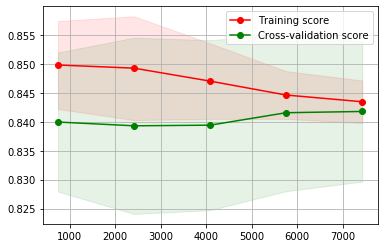

In [13]:
euclidClf = EuclideanClassifier ()
train_sizes, train_scores, test_scores = learning_curve (euclidClf, X_total, y_total, cv = 5, shuffle = True, random_state = 62)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show ()

The following points are worth noting on the above result:
- *Training score*: denotes the performance of the classifier on training data of various sizes, after training on **that same** data.
    * the score worsened as the size increased. This makes sense. After all, the classifier decided based on the dataset's mean features. With an ever greater population, these features became weaker and weaker: more people meant more creativity, which translated to greater variance of the data.
    * the score's standard deviation decreased as the size increased. This happened for the same reason as above. With all the greater variance, it became more and more statistically certain that the classifier would underperform.
- *Cross-validation score*: denotes the classifier's performance on **unseen** test data, after training on data of various sizes and achieving the respective training score.
    * the training set size had no impact on the--large--standard deviation. This also makes sense, and indicates the inability of the mean to 'adapt'. 
    * the performance was better in the case of a large training set. Unsurprisingly, more knowledge leads to more protection against the unknown. 

## Step 14
> ***ASSUMPTION:*** The discrimination between training and test data should be maintained. The probabilities were to be calculated as regards the training dataset.

The a priori probabilities were calculated with the following method. Frequencies were derived for each of the samples, and then divided with the population size.

```python
def probGen (patterns):
    """
    Returns a vector of probabilities, based on the frequency
    of each pattern in the data.
    """
    probz = np.zeros((10,), dtype = float)
    for i in range (10):
        probz[i] = (patterns == i).sum () / patterns.size
    return probz
```

The following code calculated the a priori probabilities on the training data, and also visualized the results. The formula 

$$P(\omega_i) = {N_{\omega_i} \over N_{total}}$$ 

was used.

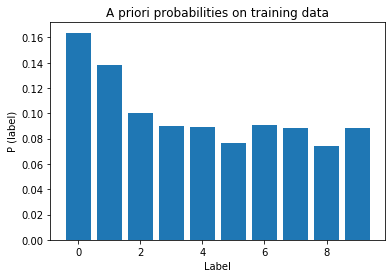

In [14]:
aPriori_train = datautilus.probGen (y_train)
xaxis = np.arange (10)
plt.bar (xaxis, aPriori_train)
plt.title ('A priori probabilities on training data')
plt.xlabel ('Label')
plt.ylabel ('P (label)')
plt.show ()

A clear over-representation of digits '0' and '1' is observable. On the figure for Step 9, the colorbars for each subplot indicate much stronger mean values for these 2 digits than the rest. Specifically, they peak at 0.75 in contrast to 0.5, or even 0.2, which hold for other numbers.

## Step 15


According to the Naive Bayes decision rule, all features are statistically independent from each other. Consequently, each feature was modelled as being generated from a univariate Gaussian distribution. Thus, each class-conditional probability was viewed as:

$$p(\textbf x |\omega_i) = \prod_{j=1}^{256} p(x_j | \omega_i)$$
$$p(\textbf x |\omega_i) = \prod_{j=1}^{256}{1 \over \sqrt{2\pi \sigma^2}} e^{- {(x_j - \mu_{ji})}^2 \over {2\sigma^2}}$$

Features resembling zero variance could not take part in the above calculation. As shown below, this does not affect the classifier's performance negatively.

Finally, the classifier should:
- take the priors into consideration
- be as accurate as possible in its calculations

Combining the above with Bayes decision theory, and introducing logarithms to eliminate multiplications, the following formulation of the rule was produced:

$$p(\omega_i | \textbf x) \propto ln(P(\omega_i)) + \sum_{j = 1}^{256} -{{(x_j - \mu_{ji})}^2 \over {2\sigma^2}} - {1 \over 2}ln(2\pi \sigma^2)$$

The Naive Bayes classifier was implemented via the ```NaiveBayesClassifier``` class, code for which can be found in [this][NB] module. The decision rule described above is part of the ```bayesHelp``` function (invoked through the classifier's ```predict``` method), shown in the following snippet:

```python
def bayesHelp (means, vars, priors, features, smooth_fac):
    """
    Performs naive Gaussian Bayes inference on a set of features,
    given their respective means, vars and priors.
    """
    init_preds = np.zeros ((features.shape[0], 10))
    #Based on scikit-learn's GaussianNB implementation.
    if smooth_fac != 0:
        vars += smooth_fac * vars.max ()
    for i in range (10):
        dig_cov  = vars[i, :]
        #Keep only the non-zero variance features, to avoid
        #NaN's when calculating Gaussian pdf.
        idx = dig_cov != 0
        dig_mean = means[i, :]
        prob = - (features[:, idx] - dig_mean[idx]) ** 2 /     \
               (2 * dig_cov[idx])
        #Choose logarithm notation; consecutive multiplications
        #of small numbers harm accuracy.
        prob -= 0.5 * np.log (2 * np.pi * dig_cov[idx])
        #Add the prior!
        init_preds [:, i] = prob.sum (1) +              \
                            np.log (priors[i])
    return init_preds.argmax (axis == 1)
```

The ```smooth_fac``` parameter is owed to a soon-to-be-presented detail. It was incorporated in later stages for code economy, and has no value at this point.

[NB]: <https://github.com/cappadokes/patrec19/blob/master/labOne/src/sklearn_classifiers.py>

In [15]:
myNB = NaiveBayesClassifier ()
print ('Classifier initialized! Fitting...')
myNB.fit (X_train, y_train)
print ('Fit complete. Score is ', myNB.score (X_test, y_test))

Classifier initialized! Fitting...
Fit complete. Score is  0.7757847533632287


In [16]:
skNB = GaussianNB ()
skNB.fit (X_train, y_train)
print ('The respective score for scikit-learn Gaussian Naive Bayes is: ', skNB.score (X_test, y_test))

The respective score for scikit-learn Gaussian Naive Bayes is:  0.7194818136522172


Surprisingly, the custom-made classifier outperformed the one imported from scikit-learn. By inspecting the [documentation][doc], it can be found out that ```GaussianNB``` uses a smoothing parameter, namely:
> ```var_smoothing``` : float, optional (default=1e-9)
>
>    Portion of the largest variance of all features that is added to variances for calculation stability.

By further examination of the class' [code][cod], no other major differences were found between the 2 implementations. ```GaussianNB``` also uses logarithms for prediction, and takes the class priors into consideration.

***HYPOTHESIS:*** By eliminating zero-variance'd features during prediction, some kind of dimensionality reduction was accidentally performed, which improved performance.

The above is worth examining. The class was slightly modified into a new version, ```NaiveBayesClassifierSmooth```. In there, a fraction of the largest variance was added to all variances . The value **1e-9** was used for the fraction, since this is sk-learn's default. 

```python
class NaiveBayesClassifierSmooth(BaseEstimator, ClassifierMixin):
    #...same code...
    def predict (self, X):
        return bayesHelp (self.X_mean, self.X_var.shape, self.aPriori,
                          X, 1e-9)
```

Results below.

[doc]: <https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html>
[cod]: <https://github.com/scikit-learn/scikit-learn/blob/1495f6924/sklearn/naive_bayes.py#L106>

In [17]:
myNB_smooth = NaiveBayesClassifierSmooth ()
print ('Classifier initialized! Fitting...')
myNB_smooth.fit (X_train, y_train)
print ('Fit complete. Score is ', myNB_smooth.score (X_test, y_test))

Classifier initialized! Fitting...
Fit complete. Score is  0.7194818136522172


The results are now identical with scikit-learn.

## Step 16
One more classifier class (```NaiveBayesClassifierOnes```) was implemented for this step.

```python
    def predict (self, X):
        return bayesHelp (self.X_mean, np.ones (self.X_var.shape),
                          self.aPriori, X, 0)
```

By applying universal unitary variance, the classifier focuses only on the features' mean values. This is one step closer to the initial Euclidean classifier.

In [18]:
myNB_ones = NaiveBayesClassifierOnes ()
print ('Classifier initialized! Fitting...')
myNB_ones.fit (X_train, y_train)
print ('Fit complete. Score is ', myNB_ones.score (X_test, y_test))

Classifier initialized! Fitting...
Fit complete. Score is  0.8126557050323866


The performance now was almost identical with the euclidean classifier (still, cross validation would be needed to concretely back this statement).

But **why** does a false statement about the data have such positive impact on the performance? Well, 'false statement' is one way to see it. An alternative would be 'infusing the classifier with expert knowledge'. The decision to apply universal unitary variance **could** be, for example, inspired by the euclidean classifier's earlier success.

> ***CAUTION:*** The above is not much more than intuitive thoughts. Someone more experienced (or more educated in statistics, or both) should give a more convincing answer.

## Step 17
For as fair comparison of the classifiers as possible, learning curves were used. Thus the code used in Step 13c was packaged in the below method:

```python
def plotLearningCurve (clf, features, patterns, cv):
    train_sizes, train_scores, test_scores = learning_curve (clf,
                                                             features,
                                                             patterns,
                                                             cv = cv,
                                                             shuffle = True,
                                                             random_state = 62)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
```
Some comparison-related points and decisions worth mentioning:
- the same seed was used along all simulations, to ensure statistical significance of the comparison.
- this step was a chance to compare the 3 Naive Bayes variants 'discovered' up to this point.
    - including 3 flavors of each classifier was also deemed reasonable
- regarding **SVM's**: the [```NuSVC```][nu] implementation was chosen.
    - to avoid warning messages in the output, the ```gamma``` parameter was given the value 'scale'.
- regarding [```KNeighborsClassifier```][knn]: Plotting the learning curve for as little as 5 neighbors also proved quite demanding (in comparison to calls made up to this point). So the values picked were {1, 3, 5} neighbors.
    - the 1-neighbor case is deceptively similar to the Euclidian Classifier. The difference here is that distances are calculated not from the mean values of the features, but from the training samples themselves.
    - additionally, after a ~~naive~~ Google search, and drawing evidence from [this][comp] article, the ```BallTree``` algorithm was selected as a parameter, since it seems to scale better both with the dimensionality and the dataset size of the problem.
    
Below is the code and figures of the comparison.

[comp]: <https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/>
[nu]: <https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC>
[svc]: <https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC>
[knn]: <https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html>

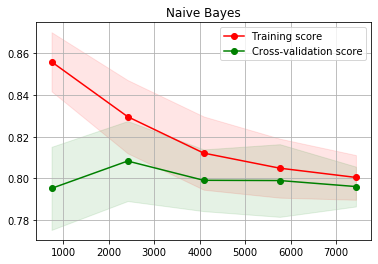

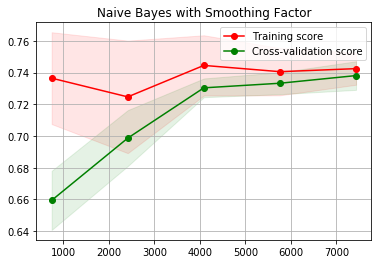

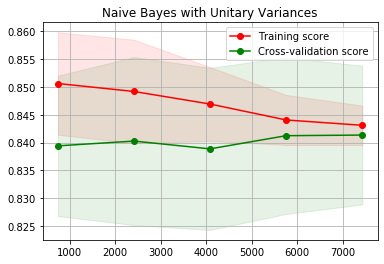

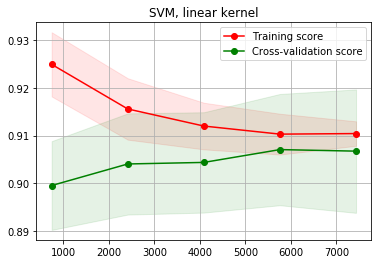

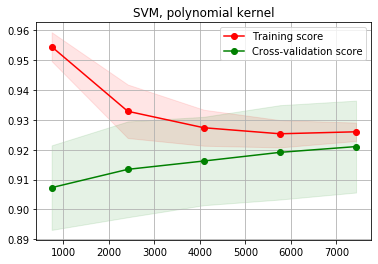

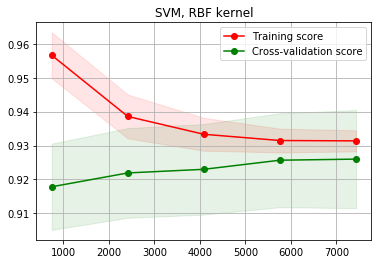

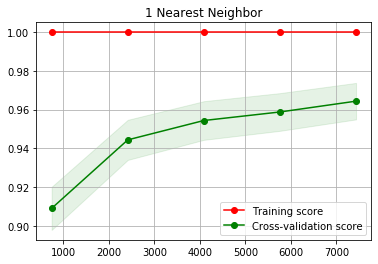

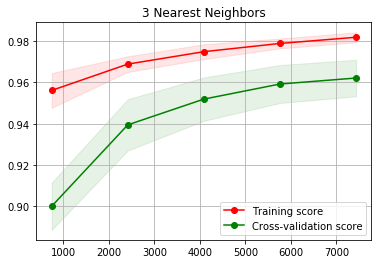

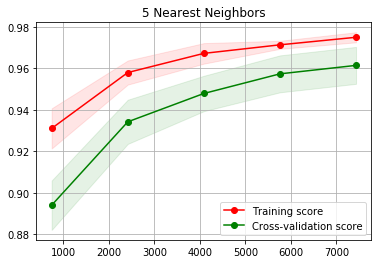

In [19]:
oneMoreBayes = NaiveBayesClassifier ()
datautilus.plotLearningCurve (oneMoreBayes, X_total, y_total, 5)
plt.title ('Naive Bayes')
plt.show ()

oneMoreBayesSmooth = NaiveBayesClassifierSmooth ()
datautilus.plotLearningCurve (oneMoreBayesSmooth, X_total, y_total, 5)
plt.title ('Naive Bayes with Smoothing Factor')
plt.show ()

oneMoreBayes1 = NaiveBayesClassifierOnes ()
datautilus.plotLearningCurve (oneMoreBayes1, X_total, y_total, 5)
plt.title ('Naive Bayes with Unitary Variances')
plt.show ()

SVC_linear = NuSVC (kernel = 'linear', gamma = 'scale')
datautilus.plotLearningCurve (SVC_linear, X_total, y_total, 5)
plt.title ('SVM, linear kernel')
plt.show ()

SVC_poly = NuSVC (kernel = 'poly', gamma = 'scale')
datautilus.plotLearningCurve (SVC_poly, X_total, y_total, 5)
plt.title ('SVM, polynomial kernel')
plt.show ()

SVC_RBF = NuSVC (kernel = 'rbf', gamma = 'scale')
datautilus.plotLearningCurve (SVC_RBF, X_total, y_total, 5)
plt.title ('SVM, RBF kernel')
plt.show ()

_1NN = KNeighborsClassifier (n_neighbors = 1, algorithm = 'ball_tree')
datautilus.plotLearningCurve (_1NN, X_total, y_total, 5)
plt.title ('1 Nearest Neighbor')
plt.show ()

_3NN = KNeighborsClassifier (n_neighbors = 3, algorithm = 'ball_tree')
datautilus.plotLearningCurve (_3NN, X_total, y_total, 5)
plt.title ('3 Nearest Neighbors')
plt.show ()

_5NN = KNeighborsClassifier (n_neighbors = 5, algorithm = 'ball_tree')
datautilus.plotLearningCurve (_5NN, X_total, y_total, 5)
plt.title ('5 Nearest Neighbors')
plt.show ()

The Nearest Neighbors algorithms achieved the highest performance. An interesting aspect is the non-convergent nature of the learning curves. Accuracy got all the better as size increased. Also, the 1-Nearest Neighbor flavor performed significantly better than the Euclidian Classifier. It is now all the more clear, that if one wants to measure euclidean distance, and performance is one's topmost concern, one had better measure it from the actual samples, not from their mean-valued representations.

> ***CAUTION:*** The training score for the 1-Neighbor case is not as impressive as it seems! The closest neighbor to a sample included in the training data is the sample itself, thus the prediction will always be correct.

SVM's performed slightly worse. The RBF kernel achieved the best score.

The only aspect in which Naive Bayes was superior was the training time, and thus its energy efficiency. The algorithm took several orders of magnitude less time to produce its results. An edge computing application with no access to the cloud and constraints on its energy use would have to think twice before choosing KNN.

> [**Green AI**][GAI] should, and inescapably will, capture more and more the attention of the field's researchers. The above comment was included in this context.

Some final remarks, with respect to the relationship between Naive Bayes with Unitary Variance and the Euclidean Classifier, are:
- with cross-validation now performed, it is safe to say that opting for unitary variances makes Naive Bayes perform almost identically with the Euclidean Classifier. Why this happens is not clear intuitively, apart from the already mentioned focus on mean values.
- $\pm 1\%$ variance is **not** large, as was mentioned in Step 13c. In fact, on this step we realize that all classifiers demonstrate equal ol larger variance on their cross validation score.

[GAI]: <https://arxiv.org/abs/1907.10597>

## Step 18
A first step to tackle this question was to select the classifiers that would do the voting. To do this, each classifier's score in a single class was compared. Thus the final approach was:
- select an initial pool of classifiers, based on Step 17's results.
- train the pool on the training data
- collect the pool's predictions on the test data
- divide the predictions class-wise
- for each classifier, plot its class-wise performance
- decide on the final voting group based on plot

A very interesting question was: would this approach give a clearer insight on which voting group should be chosen, opposed to just choosing from the learning curves of the previous step? To answer this, a 'best-at-first-sight' group was defined:

- 1-NN
- SVM RBF
- NBUV (Unitary variance Naive Bayes) 

Back to constructing the ```VotingClassifier```, the initial pool basically consisted of everything available:
- EC (Euclidean Classifier)
- NB
- NBSF (Smoothing factor Naive Bayes)
- NBUV
- 1-NN
- 3-NN
- 5-NN
- SVML
- SVMPOLY
- SVMRBF

In [20]:
EC = EuclideanClassifier ()
NB = NaiveBayesClassifier ()
NBSF = NaiveBayesClassifierSmooth ()
NBUV = NaiveBayesClassifierOnes ()
_1NN_ = KNeighborsClassifier (n_neighbors = 1, algorithm = 'ball_tree')
_3NN_ = KNeighborsClassifier (n_neighbors = 3, algorithm = 'ball_tree')
_5NN_ = KNeighborsClassifier (n_neighbors = 5, algorithm = 'ball_tree')
SVML = NuSVC (kernel = 'linear', gamma = 'scale')
SVMPOLY = NuSVC (kernel = 'poly', gamma = 'scale')
SVMRBF = NuSVC (kernel = 'rbf', gamma = 'scale')

Next, each of the classifiers was fitted on the training data and subsequently each classifier's predictions on the test data were collected:

In [21]:
EC.fit (X_train, y_train)
NB.fit (X_train, y_train)
NBSF.fit (X_train, y_train)
NBUV.fit (X_train, y_train)
_1NN_.fit (X_train, y_train)
_3NN_.fit (X_train, y_train)
_5NN_.fit (X_train, y_train)
SVML.fit (X_train, y_train)
SVMPOLY.fit (X_train, y_train)
SVMRBF.fit (X_train, y_train)

EC_preds = EC.predict (X_test)
NB_preds = NB.predict (X_test)
NBSF_preds = NBSF.predict (X_test)
NBUV_preds = NBUV.predict (X_test)
_1NN__preds = _1NN_.predict (X_test)
_3NN__preds = _3NN_.predict (X_test)
_5NN__preds = _5NN_.predict (X_test)
SVML_preds = SVML.predict (X_test)
SVMPOLY_preds = SVMPOLY.predict (X_test)
SVMRBF_preds = SVMRBF.predict (X_test)

EC_score = EC.score (X_test, y_test)
NB_score = NB.score (X_test, y_test)
NBSF_score = NBSF.score (X_test, y_test)
NBUV_score = NBUV.score (X_test, y_test)
_1NN__score = _1NN_.score (X_test, y_test)
_3NN__score = _3NN_.score (X_test, y_test)
_5NN__score = _5NN_.score (X_test, y_test)
SVML_score = SVML.score (X_test, y_test)
SVMPOLY_score = SVMPOLY.score (X_test, y_test)
SVMRBF_score = SVMRBF.score (X_test, y_test)

A method that when given a set of sample labels and their corresponding predictions, would return an array of class-wise scores was then needed. This method is shown below:

```python
def classScores (patterns, predictions):
    """
    Given a set of predictions and the respective samples' true labels, returns
    an array of class-wise accuracies. Used in the context of constructing a
    Voting Classifier.
    """
    for i in range (10):
        cc[i] = (patterns[patterns == i] == predictions[patterns == i]).sum () \
                / patterns[patterns == i].size
    return cc
```

Next, data was collected:

In [22]:
EC_cc = datautilus.classScores (y_test, EC_preds)
NB_cc = datautilus.classScores (y_test, NB_preds)
NBSF_cc = datautilus.classScores (y_test, NBSF_preds)
NBUV_cc = datautilus.classScores (y_test, NBUV_preds)
_1NN_cc = datautilus.classScores (y_test, _1NN__preds)
_3NN_cc = datautilus.classScores (y_test, _3NN__preds)
_5NN_cc = datautilus.classScores (y_test, _5NN__preds)
SVML_cc = datautilus.classScores (y_test, SVML_preds)
SVMPOLY_cc = datautilus.classScores (y_test, SVMPOLY_preds)
SVMRBF_cc = datautilus.classScores (y_test, SVMRBF_preds)

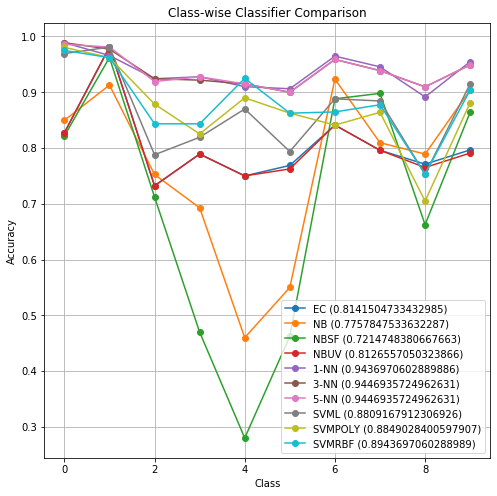

In [23]:
xaxis = np.arange (10)
fig, ax = plt.subplots(1, figsize = (8, 8))
ax.grid ()
ax.plot (xaxis, EC_cc, 'o-', label = 'EC (' + str (EC_score) + ')')
ax.plot (xaxis, NB_cc, 'o-', label = 'NB (' + str (NB_score) + ')')
ax.plot (xaxis, NBSF_cc, 'o-', label = 'NBSF (' + str (NBSF_score) + ')')
ax.plot (xaxis, NBUV_cc, 'o-', label = 'NBUV (' + str (NBUV_score) + ')')
ax.plot (xaxis, _1NN_cc, 'o-', label = '1-NN (' + str (_1NN__score) + ')')
ax.plot (xaxis, _3NN_cc, 'o-', label = '3-NN (' + str (_3NN__score) + ')')
ax.plot (xaxis, _5NN_cc, 'o-', label = '5-NN (' + str (_5NN__score) + ')')
ax.plot (xaxis, SVML_cc, 'o-', label = 'SVML (' + str (SVML_score) + ')')
ax.plot (xaxis, SVMPOLY_cc, 'o-', label = 'SVMPOLY (' + str (SVMPOLY_score) + ')')
ax.plot (xaxis, SVMRBF_cc, 'o-', label = 'SVMRBF (' + str (SVMRBF_score) + ')')
plt.xlabel ('Class')
plt.ylabel ('Accuracy')
plt.title ('Class-wise Classifier Comparison')
plt.legend (loc = 'best')
plt.show()

Now, the superiority of K-NN is obvious. For no digit does exist a classifier that performed significantly better than the 3 K-NN's. Interesting is, also, the exact same score of the 3-NN and 5-NN, meaning that probably, 3 neighbors is the max meaningful radius of search for this particular dataset or problem.

Based on the above, the final choice for the voting group was:

- 3-NN, due to the best overall performance.
- 1-NN, to guarantee the existence of a well-informed majority.
- SVMRBF, as the next-best performing classifier.

The group population was odd in order to avoid ties.

It suffices to say that after this plot, the question regarding the 'best-at-first-sight' classifiers was discarded.

***CAUTION:*** Admittedly, the above is not the best evidence that can be gathered for the selection. Cross validation could also be applied here.
The ```VotingClassifier``` could now be constructed. The 3 members of the group were first initialized. Then 2 voting classifiers were summoned, one with hard and one with soft voting. Then the classifiers were fitted on the training data, fed the test data, scored (both overall and calss-wise) and plotted. Also in the plots is included the performance for 1-NN, for somewhat more meaningful comparison:

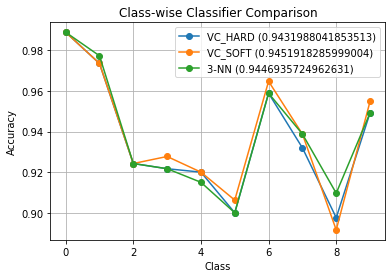

In [24]:
_1NN_= KNeighborsClassifier (n_neighbors = 1, algorithm = 'ball_tree')
_3NN_= KNeighborsClassifier (n_neighbors = 3, algorithm = 'ball_tree')
SVMRBF = NuSVC (kernel = 'rbf', gamma = 'scale', probability = True)

VC_HARD = VotingClassifier (estimators = [('1nn', _1NN_), ('3nn', _3NN_),
                                          ('rbf', SVMRBF)], voting = 'hard')
VC_SOFT = VotingClassifier (estimators = [('1nn', _1NN_), ('3nn', _3NN_),
                                          ('rbf', SVMRBF)], voting = 'soft')
VC_HARD.fit (X_train, y_train)
VC_SOFT.fit (X_train, y_train)
_3NN_.fit (X_train, y_train)

VC_HARD_preds = VC_HARD.predict (X_test)
VC_SOFT_preds = VC_SOFT.predict (X_test)
_3NN__preds = _3NN_.predict (X_test)

VC_HARD_score = VC_HARD.score (X_test, y_test)
VC_SOFT_score = VC_SOFT.score (X_test, y_test)
_3NN__score = _3NN_.score (X_test, y_test)
VC_HARD_cc = datautilus.classScores (y_test, VC_HARD_preds)
VC_SOFT_cc = datautilus.classScores (y_test, VC_SOFT_preds)
_3NN_cc = datautilus.classScores (y_test, _3NN__preds)

xaxis = np.arange (10)
fig, ax = plt.subplots(1)
ax.grid ()
ax.plot (xaxis, VC_HARD_cc, 'o-', label = 'VC_HARD (' + str (VC_HARD_score) + ')')
ax.plot (xaxis, VC_SOFT_cc, 'o-', label = 'VC_SOFT (' + str (VC_SOFT_score) + ')')
ax.plot (xaxis, _3NN_cc, 'o-', label = '3-NN (' + str (_3NN__score) + ')')
plt.xlabel ('Class')
plt.ylabel ('Accuracy')
plt.title ('Class-wise Classifier Comparison')
plt.legend (loc = 'best')
plt.show()

The results are somewhat encouraging, although a much better overall performance was expected. In general:
- the soft voting classifier achieved the best performance. The superiority over the hard voting case is probably owed to the weighted nature of deciding on probabilities, rather than on black-box recommendations.
- in 5 out of 10 digits, the 3-NN performed worse than at least one of the voting classifiers. The value of a voting ensemble is thus evident.

A rather interesting fact is the performance on digits 5 and 8, which are the least represented in the training set, as shown during calculation of the priors. In the case of 5, the soft voting classifier marked a better score. In the case of 8, **both** of the voting classifiers performed worse. A reasonable question, then, is:

> How can a 'misinformed majority' affect the overall performance of a voting classifier? Are there cases for which opting for a single, overall-best classifier is justified?

Of course, the experiment could be repeated with a voting group comprised exclusively of Nearest-Neighbors classifiers. But would this make sense? Probably not, given the absolute equivalence of 3-NN and 5-NN.

Next, the 3-NN was chosen as estimator for the ```BaggingClassifier```. It was fit on the training data, and then the score of predictions on the test data was retrieved.

In [25]:
BC = BaggingClassifier (base_estimator = _3NN_)
BC.fit (X_train, y_train)
print ('Score of the Bagging Classifier on test data: ', BC.score (X_test, y_test))

Score of the Bagging Classifier on test data:  0.9466865969108121


The bagging classifier achieved a slightly better score than the soft voting classifier, and thus its value is evident. A further investigation involving its initialization parameters was, however, **not** conducted.

## Step 19
This being a first contact with PyTorch, it was decided that the CPU-only flavor of the package will be employed for this exercise. Thus no CUDA offloading code exists below.

From this point on, and for the rest of the exercise, all needed imports will be executed just before they are used.

The first thing needed is a PyTorch-compatible dataset. For this, the following class was implemented :

```python
class DigitsDataset (Dataset):
    def __init__ (self, array):
        self.dad = array
        #FloatTensor is needed by the nn.Linear module
        self.data = torch.from_numpy (self.dad).type ('torch.FloatTensor')

    def __len__ (self):
        return self.dad.shape[0]

    def __getitem__ (self, idx):
        return self.data[idx, 1:], self.data[idx, 0]
```

The code is saved in the module [```pytorch_stuff```][pt], which is just what is imported below.

[pt]: <https://github.com/cappadokes/patrec19/blob/master/labOne/src/pytorch_stuff.py>

In [26]:
from src import pytorch_stuff as pt

The next thing to do was to create 3 [```Dataset```][DS] objects, with training, validation and test data respectively:

[DS]: <https://pytorch.org/docs/stable/data.html#dataset-types>

In [27]:
Xy_train = np.hstack ((y_train.reshape (-1, 1), X_train))
Xy_test = np.hstack ((y_test.reshape (-1, 1), X_test))
train_tensor = pt.DigitsDataset (Xy_train[0:Xy_train.shape[0] - 100, :])
valid_tensor = pt.DigitsDataset (Xy_train[Xy_train.shape[0] - 100:, :])
test_tensor = pt.DigitsDataset (Xy_test)

In order to enable mini-batches, an iterable was created using the [```DataLoader```][DS] class.

[DS]: <https://pytorch.org/docs/stable/data.html#dataset-types>

In [28]:
from torch.utils.data import DataLoader

For the training data, a batch size of 25 was defined, with the hope that it will include samples from all classes. The validation batches were twice as large. The training dataset iwasshuffled between epochs.

In [29]:
train_loader = DataLoader (train_tensor, batch_size = 25, shuffle = True)
valid_loader = DataLoader (valid_tensor, batch_size = 50, shuffle = False)

The neural network was defined by the following class:

```python
class Net0Hidden (nn.Module):
    def __init__ (self):
        super (Net0Hidden, self).__init__ ()
        self.lin = nn.Linear (256, 10)

    def forward (self, batch):
        #The activation function (log softmax) is encoded in the loss function
        #used for fitting (cross_entropy)
        return self.lin (batch)
```

As stated in the code above, logarithmic softmax was chosen as the activation function, paired with negative log likelihood as the loss function. This is an appropriate choice for multiclass classification cases like this one.

> ***CAUTION:*** The above network has no hidden layers!

Both of the functions are by default incorporated in the [```cross_entropy``` loss][CEL] function of ```torch.nn.functional```.

For training the network, the following method was written:

```python
def fit (net, epochs, lr, loader, v_loader):
    #Define loss function.
    loss_func = F.cross_entropy
    #Use Stochastic Gradient Descent of the optim package for parameter updates.
    opt = optim.SGD (net.parameters (), lr = lr)
    #A flag  for validation loss.
    old_valid_loss = -62
    for epoch in range (epochs):
        #It is wise, according to the documentation, to put the network in
        #training mode before each batch is loaded.
        net.train ()
        for xb, yb in loader:
            out = net.forward (xb)
            loss = loss_func (out, yb.type ('torch.LongTensor'))
            #Backpropagate the loss.
            loss.backward ()
            #Update weights, bias.
            opt.step ()
            #A new batch is ready to be loaded. Clean gradient memory!
            opt.zero_grad ()
        #At the end of each epoch, the network is put in evaluation mode.
        net.eval ()
        #No reason to keep the gradient for the validation set.
        with torch.no_grad ():
            valid_loss = 0
            for xb, yb in v_loader:
                valid_loss += loss_func (net.forward (xb), \
                                         yb.type ('torch.LongTensor'))
            #Early stopping!
            if old_valid_loss != -62 and valid_loss > old_valid_loss:
                break
            old_valid_loss = valid_loss
    print ('Training finished due to early stopping. Actual number of epochs: ',
           epoch)
    return net
```

The training dataset was used for parameter updates, and the validation dataset for early stopping. The method was heavily influenced by [this][tut] tutorial. The following method was used to wrap network training:

```python
def training_wrapper (net, epochs, lr, loader, v_loader, test_tensor):
    print ('Score before training: ', netScore (net, test_tensor))
    net = fit (net, epochs, lr, loader, v_loader)
    print ('Score after training: ', pt.netScore (net, test_tensor))
    return net
```

Next, the network was:
- defined
- evaluated in it random, initial state
- trained with:
    - a number of 500 max epochs
    - a learning rate of 1e-3

[CEL]: <https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss>
[tut]: <https://pytorch.org/tutorials/beginner/nn_tutorial.html>

In [30]:
network = pt.Net0Hidden ()
network = pt.training_wrapper (network, 500, 1e-3, train_loader, valid_loader, test_tensor)

Score before training:  0.09367214748380667
Training finished due to early stopping. Actual number of epochs:  260
Score after training:  0.9147982062780269


As can be seen above, the performance of a network with randomized weights is negligible. During training, it took nearly half the initial number of epochs to trigger the early stopping criterion.

The post-training score was also inspected. The network, which had **no** hidden layers, performed similarly with all the classifiers studied until now. Moreover, even though its training time was not as small as Naive Bayes', it was **much** smaller than both the SVM's and the k-NN's.

Next, a slightly more complex network was tested:

```python
class Net1Hidden (nn.Module):
    #A single hidden layer is introduced. Its size can be set upon initializing.
    def __init__ (self, hidden_size):
        super (Net1Hidden, self).__init__ ()
        self.lin1 = nn.Linear (256, hidden_size)
        #The output is kept at the same size of 10 (so that log softmax still
        #has meaning).
        self.lin2 = nn.Linear (hidden_size, 10)

    def forward (self, batch):
        #ReLU is used as activation function for the input layer.
        mid = F.relu (self.lin1 (batch))
        return self.lin2 (mid)
```

In [31]:
network_h = pt.Net1Hidden (128)
network_h = pt.training_wrapper (network_h, 500, 1e-3, train_loader, valid_loader, test_tensor)

Score before training:  0.12207274539113104
Training finished due to early stopping. Actual number of epochs:  75
Score after training:  0.9053313403089188


At this point, the intricacies of training neural networks become apparent. Why was the performance worse? How complex would the ideal architecture be, with how many hidden layers of how many neurons? Why was the early stopping criterion triggered so soon? How much smaller a learning rate should be used? What about the ReLU activation function at the input? Would a different function yield better results? And what about the solver? Would an option different than Stochastic Gradient Descent help?

Three ways to proceed exist:
- do an extremely computation-hungry brute-force parameter sweep
- make more informed design choices, depending on the nature of the problem
- a hybrid combination of the above

What is even more important is, these concerns arose for a minimal feed-forward network, hugely simpler than state-of-the-art deep neural networks. Since these look more like open problems of the field than issues to be addressed here, no more parameter combinations were examined.

The last step of the exercise was to integrate the PyTorch networks in a scikit-learn class. The ```NeuralNet0Hidden``` class was added in the [```sklearn_classifiers```][lala] module. A glimpse of the class is shown below:

```python
class NeuralNet0Hidden (BaseEstimator, ClassifierMixin):
    """
    Implements a fully connected PyTorch neural net classifier with 0 hidden
    layers.
    """

    def __init__ (self, epochs, lr):
        """
        Creates the net through invoking PyTorch class.
        """
        self.net = pt.Net0Hidden ()
        self.epochs = epochs
        self.lr = lr
```

[lala]:<>

In [32]:
skNet = NeuralNet0Hidden (500, 1e-3)
print ('Score before training: ', skNet.score (X_test, y_test))
skNet.fit (X_train, y_train)
print ('Score after training: ', skNet.score (X_test, y_test))

Score before training:  0.0916791230692576
Training finished due to early stopping. Actual number of epochs:  228
Score after training:  0.9138016940707524


Finally, in order to ensure that the PyTorch implementation had no bugs, the performance of a 1-hidden layer neural network (class ```NeuralNet1Hidden```) was compared to that of an equivalently initialized ```MLPClassifier```, as it is defined [here][MLP].

[MLP]: <https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html>

In [33]:
skMLP = MLPClassifier (hidden_layer_sizes = (100,), solver = 'sgd',
                       batch_size = 25, max_iter = 500, early_stopping = True,
                       validation_fraction = 0.01)
skNet1H = NeuralNet1Hidden (500, 1e-3, 100)
skMLP.fit (X_train, y_train)
skNet1H.fit (X_train, y_train)
print ('MPLClassifier test score: ', skMLP.score (X_test, y_test))
print ('PyTorch classifier test score: ', skNet1H.score (X_test, y_test))

Training finished due to early stopping. Actual number of epochs:  76
MPLClassifier test score:  0.9162929745889388
PyTorch classifier test score:  0.9063278525161933


The scores were close enough. The ```MLPClassifier``` is more sophisticated than the PyTorch one, after all. As evident in the [documentation][MLP], it also uses a momentum term for gradient descent updates, plus a regularization term for the loss function.

[MLP]: <https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html>